# Import/Initialize

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm.notebook import tqdm

import time
from PIL import Image
import cv2
from skimage.color import rgba2rgb
from skimage.io import imread
import copy

from collections import OrderedDict

In [2]:
CHANNEL_N = 16
RADIUS = 1
NUM_FILTERS = 2
HIDDEN_N = 128

TARGET_SIZE = 40
TARGET_PADDING = 16
BATCH_SIZE = 10

In [6]:
class Filter(nn.Module):
    def __init__(self, r=RADIUS, symmetric=True):
        super().__init__()
        
        
        f = torch.randn(2*r + 1)
        if symmetric:
            f = (f + f.flip(0))/2
        f = torch.ger(f, f)
#         f[r, r] = 0
        f = f - f.mean()
#         f = f - f.sum()/(f.numel() - 1)
#         f[r, r] = 0
        
        self.kernel = nn.Parameter(f)


class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, r=RADIUS, num_filters=NUM_FILTERS, hidden_n=HIDDEN_N):
        super().__init__()            
        
        self.channel_n = channel_n
        self.r = r
        self.num_filters = num_filters
        self.fire_rate = 0.5
        
        # define identity matrix
        identity = torch.zeros(2*self.r + 1)
        identity[self.r] = 1
        self.identity = torch.ger(identity, identity)
        self.identity = nn.Parameter(self.identity, requires_grad=False)

        # initialize perception kernel (trainable) 
#         self.rand_filters = [Filter(self.r, symmetric=True).kernel for i in range(self.num_filters)]
        
#         self.filters = nn.ParameterList([self.identity] + self.rand_filters)
        
        # Sobel filters
        self.sx = torch.ger(torch.FloatTensor([1, 2, 1]), torch.FloatTensor([-1, 0, 1])) / 8
        self.sx = nn.Parameter(self.sx, requires_grad=False)
        self.sy = nn.Parameter(self.sx.T.type(torch.FloatTensor), requires_grad=False)
#         self.filters = [torch.cuda.FloatTensor(self.sx), torch.cuda.FloatTensor(self.sy)]
        
        
        # 1D conv network
        self.dmodel = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n, 1, padding_mode='circular')),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(hidden_n, self.channel_n, 1, padding_mode='circular')),
        ]))
        
        # update rule - initialized with zeros so initial behaviour is 'do nothing' (trainable)
#         nn.init.zeros_(self.dmodel.conv2.weight)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv1.weight)
#         nn.init.zeros_(self.dmodel.conv2.bias)

         
    def perceive(self, x):              
#         filters = [self.identity] + [f.kernel for f in self.rand_filters]
        filters = [self.identity, self.sx, self.sy]
#         filters = [f for f in self.filters]
        numFilters = len(filters)
        k_size = 2*self.r + 1
        
        filters = torch.stack(filters).unsqueeze(0)
        filters = torch.repeat_interleave(filters, self.channel_n, dim=0)
        filters = filters.view(self.channel_n*numFilters, 1, k_size, k_size)  # combine filters into batch dimension (or out dimension, idk)
        
        # depthwise conv2d (groups==self.channel_n)
        x = F.pad(x, (self.r, self.r, self.r, self.r), mode='circular')
        y = F.conv2d(x, filters, padding=self.r, groups=self.channel_n) 
        y = y[:, :, self.r:-self.r, self.r:-self.r]
        return y
    
    def get_living_mask(self, x):
        alpha_channel = x[:, 3:4, :, :]
        alpha_channel = F.pad(alpha_channel, (self.r, self.r, self.r, self.r), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) > 0.1
        alive_mask = alive_mask[:, :, self.r:-self.r, self.r:-self.r]
        return alive_mask.cuda()
    
    def forward(self, x, fire_rate=None, step_size=1.0):
        
        pre_life_mask = self.get_living_mask(x)
        
        y = self.perceive(x)
        dx = self.dmodel(y) * step_size 
        
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).type(torch.FloatTensor).cuda()
        x = x + dx * update_mask
        
        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).type(torch.FloatTensor).cuda()
        
        x = x * life_mask
 
        return x

def to_rgba(x):
    return x[:, :4, :, :]

def to_alpha(x):
    return np.clip(x[:, 3:4, :, :], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[:, :3, :, :], to_alpha(x)
    return 1.0-a+rgb

def load_image(fname, max_size=TARGET_SIZE):
    img = Image.open(fname)
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

# Run for fun (remove zero weight initialization on final layer)

In [9]:
CA_run = CAModel()

if torch.cuda.is_available():
    CA_run.cuda()

450


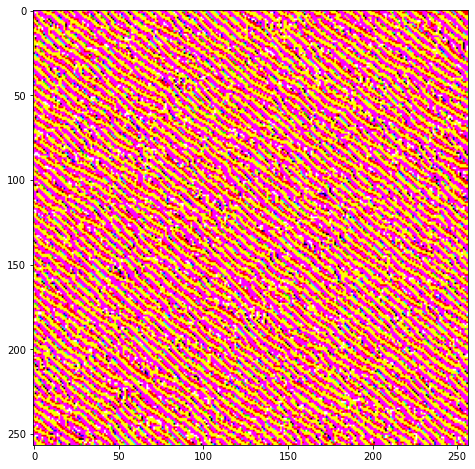

D:\Anaconda\envs\NN_CA\lib\site-packages\skimage\color\colorconv.py:209: RuntimeWarning: invalid value encountered in add
  (1 - alpha) * background[ichan] + alpha * channels[..., ichan],


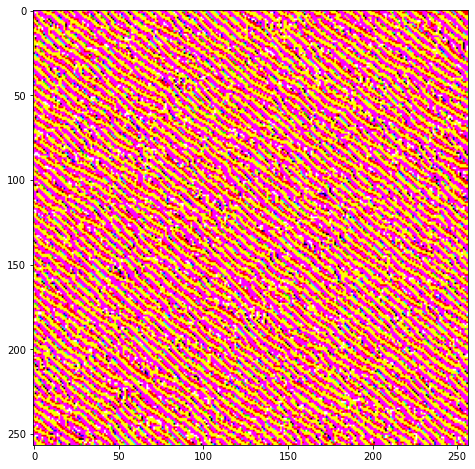

In [10]:
SIZE = 257

x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, 256//3 : 2*256//3, 256//3 : 2*256//3] = 1

# x[:, 3:, SIZE//3, SIZE//3] = 1
# x[:, 3:, 2*SIZE//3, 2*SIZE//3] = 1

imgs = []

timeSteps = 500
for i in range(timeSteps):
#     print(i, stop)
    nx = x.cpu().numpy()[0, :4, :, :].transpose(1, 2, 0)
    nx = rgba2rgb(nx)
    imgs.append(nx)
    
    if i%50 == 0:
        plt.clf()
        plt.imshow(nx)
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        print(f'{i}')
        display(plt.gcf())
        time.sleep(0.01)

    x = CA_run.forward(x, step_size=1, fire_rate=1)    
    x = x.detach()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [4]:
CA = CAModel()
if torch.cuda.is_available():
    CA.cuda()

In [7]:
p = TARGET_PADDING
target = load_image('target.png', TARGET_SIZE).transpose(2, 0, 1)[None, ...]

pt = torch.cuda.FloatTensor(target)
pt = torch.repeat_interleave(pt, BATCH_SIZE, dim=0)

pt = F.pad(pt, (p, p, p, p))
h, w = pt.shape[2:]

In [6]:
optim = torch.optim.Adam(CA.parameters(), lr=2e-3)

In [360]:
for p in optim.param_groups:
    p['lr'] = 1e-5

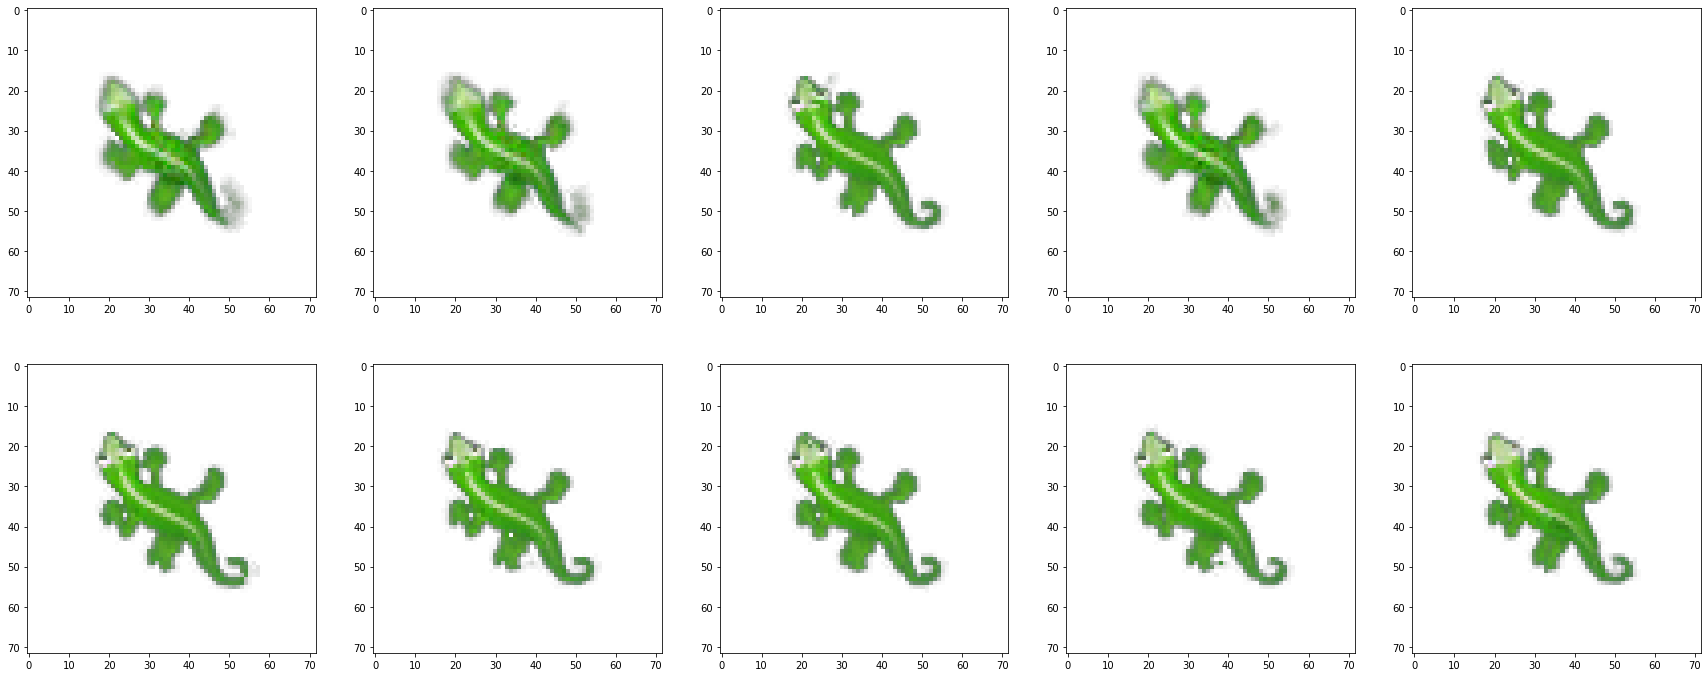

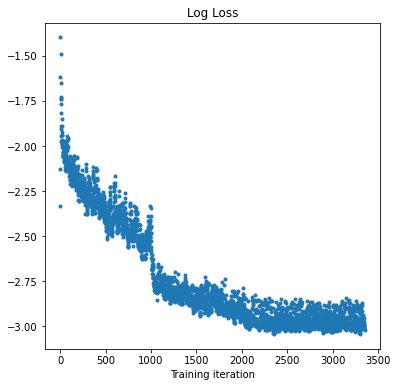

MemoryError: Unable to allocate 1.54 MiB for an array with shape (3, 13, 72, 72) and data type float64

In [11]:
PERSISTENT = True
NUM_RESET = 3
if PERSISTENT:
    mse = nn.MSELoss(reduction='none')
else:
    mse = nn.MSELoss(reduction='mean')

total_loss = []

for j in tqdm(range(4000), leave=True):
    optim.zero_grad()
    imgs = []
    
    if PERSISTENT and j > 1:
        # replace batch index with worst loss with seed image
        x[indices[-NUM_RESET:], 3:, :, :] = torch.cuda.FloatTensor(np.zeros((NUM_RESET, CHANNEL_N-3, h, w)))
        x[indices[-NUM_RESET:], 3:, h//2, w//2] = 1.0
    else:
        x = torch.cuda.FloatTensor(np.zeros((BATCH_SIZE, CHANNEL_N, h, w)))
        x[:, 3:, h//2, w//2] = 1.0
            
    
    if j == 1000:
        for p in optim.param_groups:
            p['lr'] = 2e-4
            
    if j == 2000: 
        for p in optim.param_groups:
            p['lr'] = 2e-5

    iter_num = np.random.randint(64,96)
    for i in range(iter_num):
        
        
        ##### PLOTTING THINGS #####
        if j % 50 == 0:
            b_nx = []
            for batch_idx in range(0, BATCH_SIZE):
                nx = x.cpu().detach().numpy()[batch_idx, 0:4, :, :].transpose(1, 2, 0)
                nx = rgba2rgb(nx)
                nx = np.uint8(nx*255.0)
                b_nx.append(nx)
            imgs.append(b_nx)

            if (i+1)%iter_num == 0:
                display.clear_output(wait=True)
                fig1, axes = plt.subplots(2, 5, figsize=(30, 12))  # for a BATCH_SIZE of 6
                if isinstance(axes, np.ndarray):
                    for i_ax, ax in enumerate(axes.flatten()):
                        ax.imshow(imgs[-1][i_ax])
                else:
                    axes.imshow(imgs[-1][0])
                    
                fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))
                ax2.plot(np.log10(total_loss), '.')
                ax2.set_title('Log Loss')
                ax2.set_xlabel('Training iteration')
                
                plt.show()
        ###########################
        
        x = CA.forward(x, step_size=1, fire_rate=0.5)
            
    
    loss = mse(to_rgba(x), pt)
    if PERSISTENT:
        loss_sorted = loss.view(10, -1).sum(dim=1).detach()
        loss = loss.mean()
        _, indices = torch.sort(loss_sorted)
    
    total_loss.append(loss.detach())         
    loss.backward()
    
    # normalize gradients
    for p in CA.parameters():
        if p.grad is not None:
            p.grad = p.grad / (1e-8 + torch.norm(p.grad))
        
    optim.step()

    x = x.detach() 
    
    if j % 100 == 0:
        fname = f'model/CA_{j}_' + time.strftime("%Y%m%d-%H%M%S")
        torch.save(CA, fname)


In [357]:
for i in range(0, BATCH_SIZE):
    ex_img = np.array(imgs)[:, i, :, :, :]

    fname = time.strftime("%Y%m%d-%H%M%S") + f'_{i}'
    out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (h, w), 3)

    for img in ex_img[:]:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
    out.release()

# Run Trained Model

In [10]:
CA = torch.load('model/CA_3300_20200325-013406')

550


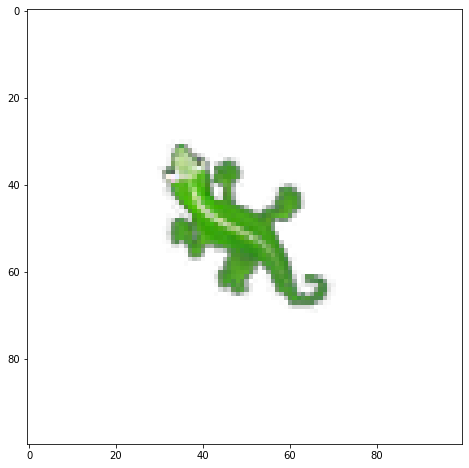

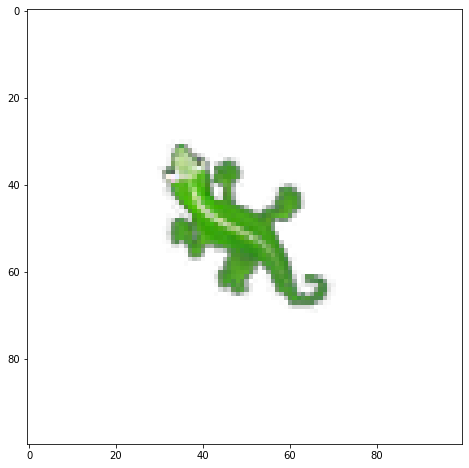

In [14]:
# x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, 256, 256))).unsqueeze(0)
SIZE = 100
x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
x[:, 3:, SIZE//2, SIZE//2] = 1
imgs = []

for i in range(600):
    
    with torch.no_grad():
        nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
    #     nx = np.uint8(nx*255.0)
        imgs.append(nx)

        x = CA.forward(x, step_size=1, fire_rate=0.5)
        x = x.detach()


        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [32]:
fname = 'model/CA_model_' + time.strftime("%Y%m%d-%H%M%S") + '.pb'
torch.save(CA.dmodel, fname)

In [30]:
CA = CAModel()

CA.dmodel = torch.load(fname)
CA.cuda()

CAModel(
  (dmodel): Sequential(
    (conv1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)